In [1]:
# graph attention

In [9]:
import dgl
import numpy as np
import torch
from torch import nn
from dgl.nn import GraphConv

def GraphConvDGL(g):
    g.add_self_loop()


In [3]:
g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))

In [4]:
g.add_self_loop()

Graph(num_nodes=6, num_edges=12,
      ndata_schemes={}
      edata_schemes={})

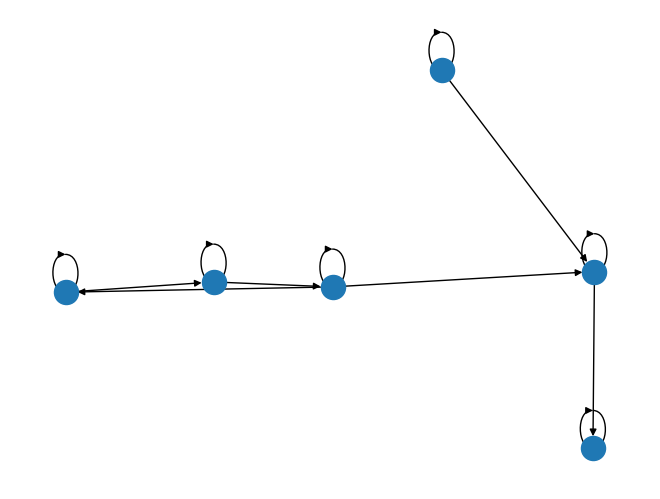

In [6]:
import networkx as nx



nx.draw(g.add_self_loop().to_networkx())

In [10]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """

        Args:
            node_feats (_type_): batch_size, n, m
            adj_matrix (_type_): n*n
        """
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [11]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [12]:
layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])
